In [5]:
import os
import torch
from glob import glob 

from torch.utils import data
from pytorch_ssn.model.SSN import SSN, crop_like, superpixel_flow, superpixel_seg
from pytorch_ssn.model.util import get_spixel_image

import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import pytorch_ssn.IO as IO
from pytorch_ssn.connectivity import enforce_connectivity


from utils.optical_flow import computedepth, computeflow
from pytorch_ssn.RAFT.core.raft import RAFT
from pytorch_ssn.model.ResUnet import ResUnet

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


class ARGS:
    def __init__(self):
        self.n_spixels=100
        self.num_steps=10
        self.result_dir='./results/pix/'
        self.pre_dir='./pytorch_ssn/model/slic_model/45000_0.527_model.pt'        
        self.root = 'data'
        self.flownet_dir = "./pytorch_ssn/model/flow_model/raft-kitti.pth"    
        self.mixed_precision = True; self.alternate_corr=False; self.dropout = 0.0
        self.small_ = False
        # for unet

        self.save_path = "./checkpoints/unetsmall"
        self.small= False
        if not self.small:
            self.save_path = "./checkpoints/unetbig"
        self.unetmodel = f"{self.save_path}/best.pth"
args = ARGS()

def imgtensor2np(img):
    return img.permute(1,2,0).detach().cpu().numpy()
def to_device(args, device):
    args_out = []
    for arg in args:
        if isinstance(arg, list):
            arg = [ elem.to(device) for elem in arg ]
        else:
            arg = arg.to(device)
        args_out.append(arg)
    return args_out


def connect_segments(new_spix_indices, num_h, num_w, h, w):
    new_spix_indices = new_spix_indices[0]
    new_spix_indices = new_spix_indices[:, :h, :w].contiguous()
    spix_index = new_spix_indices.cpu().numpy()[0]
    spix_index = spix_index.astype(int)

    segment_size = (h * w) / (int(num_h*num_w) * 1.0)
    min_size = int(0.06 * segment_size)
    max_size = int(3 * segment_size)
    spix_index = enforce_connectivity(spix_index[np.newaxis, :, :], min_size, max_size)[0]
    spix_index = torch.tensor(spix_index).unsqueeze(0).unsqueeze(0).to(device)
    return spix_index

def segmentfromLabels(given_img, new_spix_indices, num_h,num_w, connect=False):
    h, w = given_img.shape[0], given_img.shape[1]
    new_spix_indices = new_spix_indices[:, :h, :w].contiguous()
    spix_index = new_spix_indices.cpu().numpy()[0]
    spix_index = spix_index.astype(int)

    if connect:
        segment_size = (given_img.shape[0] * given_img.shape[1]) / (int(num_h*num_w) * 1.0)
        min_size = int(0.06 * segment_size)
        max_size = int(3 * segment_size)
        spix_index = enforce_connectivity(spix_index[np.newaxis, :, :], min_size, max_size)[0]

    return  get_spixel_image(given_img, spix_index)


# slic layer
SSNLayer = SSN(args.pre_dir, spixel_size=(5,5),dtype = 'layer', device = device)


# flow network
net = torch.nn.DataParallel(RAFT(args))
net.load_state_dict(torch.load(args.flownet_dir))
net = net.module.to(device)
print("Parameter Count: %d" % net.count_parameters())


cuda
Parameter Count: 5257536


In [22]:
from tartandataloader import TartanLoader 
from torch.utils.data import DataLoader
from loss import EPE, depthErrors

valset = TartanLoader(basepath = ['data/office2'], mode = 'test00', scale = 2)
val_loader = DataLoader(valset, batch_size=1, shuffle=True, num_workers=4)


Found 612 image files in P000
Test samples =  611


In [23]:
EPEs, EPEseg = [], []
means = []
net.eval()
for idx , sample in tqdm(enumerate(val_loader)):
    im0, im1, flow, flow_inliers, depth_gt, tr_gt, rot_gt, intrinsics, = to_device(sample[:-2], device)

    flow_low, flow_pr = net(im0, im1, iters=24, test_mode=True)

    ssn_input = sample[-2].to(device)  
    ssn_params = to_device(sample[-1], device)
    ssn_params.extend([None])

    _, spix_indices = SSNLayer(ssn_input, ssn_params) 
    spix_indices = crop_like(spix_indices.unsqueeze(1), im1)
    spix_indices = connect_segments(spix_indices, ssn_params[0], ssn_params[1], im0.shape[-2], im0.shape[-1])
    
    segflow_GT, _ = superpixel_flow( flow.clone(), spix_indices)        
    segflow_pred, _ = superpixel_flow( flow_pr.clone(), spix_indices)   


    depth_pred = computedepth([tr_gt, rot_gt, intrinsics, flow_pr], device) # use any flow function    
    means.append([torch.mean(depth_pred).item(), torch.mean(depth_gt).item()])
    
    gtdepthmap, pred_depthmap = imgtensor2np(depth_gt[0]).squeeze(), imgtensor2np(depth_pred[0]).squeeze()
    mask = np.logical_and(gtdepthmap > 0, gtdepthmap < 100)

    errors = depthErrors(gtdepthmap[mask], pred_depthmap[mask])
    EPEseg.append(EPE(segflow_pred, segflow_GT).item())
    EPEs.append(EPE(flow_pr, flow).item())
    break


0it [00:00, ?it/s]/home/gokul/.local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def _evaluate_nearest(self, indices, norm_distances, out_of_bounds):
/home/gokul/.local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def _evaluate_nearest(self, indices, norm_distances, out_of_bounds):
/home/gokul/.local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple seque

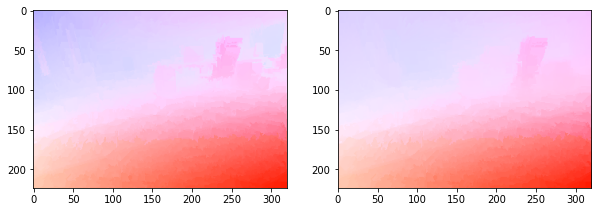

In [24]:
# [UNCOMMENT TO VISUALIZE SEGMENTED OPTICAL FLOW]
flowrgb_GT = IO.visualize_flow( imgtensor2np(segflow_GT[0]) ) 
flowrgb_pred = IO.visualize_flow(imgtensor2np(segflow_pred[0]))


## [UNCOMMENT TO VISUALIZE Regular OPTICAL FLOW]
# flowrgb_GT = IO.visualize_flow( imgtensor2np(flow[0]) ) 
# flowrgb_pred = IO.visualize_flow(imgtensor2np(flow_pr[0]))

f, plts = plt.subplots(1,2,figsize=(10,10))
plts[0].imshow(flowrgb_GT)
plts[1].imshow(flowrgb_pred)

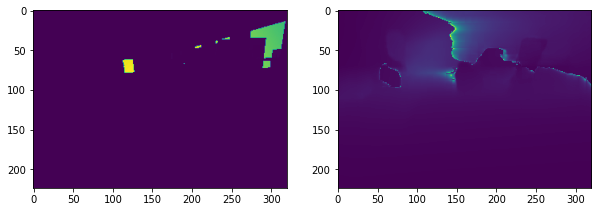

In [25]:
f, plts = plt.subplots(1,2,figsize=(10,10))
plts[0].imshow(gtdepthmap)
plts[1].imshow(pred_depthmap)